# <center>Modelling and Detecting Atmospheric Effects on Exoplanets</center>    <center>with PyLightCurve and QHx</center>

![light_curve](light_curve.png)

# <center> Overview</center>

![scopee](astrobio.png)

In [30]:
# Import neccesary packages and modules
import pylightcurve as plc
import matplotlib.pyplot as plt
import numpy as np
from QhX.plots import *
from QhX.utils import *
from QhX.algorithms.wavelets.wwtz import *
from QhX.calculation import *
from tqdm import tqdm
import contextlib
import sys
import os
import astropy.constants as const
from scipy import interpolate
import random

import warnings
warnings.filterwarnings("ignore")

@contextlib.contextmanager
def suppress_print():
    with open(os.devnull, 'w') as fnull:
        old_stdout = sys.stdout
        sys.stdout = fnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

# 1. Modelling and Detecting Atmospheric Effects for a single planet transit

## 1.1. Modelling light curve and Atmospheric Effect with PyLightCurve 

In [3]:
# === Define a planetary system ===
planet = plc.Planet(
    name='HD209458b',              # name of the planet
    
    ra = 330.795,                  # position (right ascension) of the system [degrees]
    
    dec = 18.884,                  # position (declination) of the system [degrees]
    
    stellar_logg = 4.36,           # logarithmic surface gravity of the star [log(cm/s^2)]
    
    stellar_temperature = 6065.0,  # stellar temperature [K]
    
    stellar_metallicity = 0.0,     # stellar mettalicity [dex(Fe/H) or dex(M/H)]
    
    rp_over_rs = 0.12086,          # planet-to-star radius ratio
    
    period = 3.5247486,            # period of the planet's orbit [days]
    
    sma_over_rs = 8.76,            # ratio of the semi-major axis of the planet's orbit and the stellar radius
    
    eccentricity = 0.0,            # eccentricity of the planet's orbit
    
    inclination = 86.71,           # inclination of the planet's orbit [degrees]          
    
    periastron = 0.0,              # periastron of the planet's orbit [degrees]
    
    mid_time = 2452826.62928,      # mid point of the planet's transit [days]
    
    mid_time_format = 'BJD_TDB',   # format of the mid point of the planet's transit   
    
    ldc_method = 'claret',         # limb darkening coefficient method
    
    ldc_stellar_model = 'phoenix', # stellar atmosphere model
    
    albedo = 0.15,                 # albedo of the planet
    
    emissivity = 1.0,              # thermal emissivity of the planet
)

In [4]:
def modelling_light_curve(planet):
    # === Create time array ===
    
     # The cadence in this work is based on the Zwicky Transient Facility (ZTF) transit observations
     # which typically have ~120 epochs/year (3-night cadences as in Northern-equatorial Sky Survey) 
     # or up to ~360 epochs/year (1-night cadence as in Galactic Plane-targeted Survey)
     # -- https://irsa.ipac.caltech.edu/data/ZTF/docs/releases/dr06/ztf_release_notes_dr06.pdf --
     # In this work, we choose the range 100 - 400 epochs/300 days.
        
    baseline_days = 365                                 # baseline duration of the observation [days]
    num_epochs = random.sample(range(120, 400),1)[0]       # number of epoch of the observation
    central_mid_time = planet.mid_time                  # get mid Point of the observation

    np.random.seed(0)
    obs_time_array = np.sort(np.random.uniform(0, baseline_days, num_epochs))
    centered_time_array = obs_time_array - np.mean(obs_time_array)
    time_array = central_mid_time + centered_time_array

    # === Compute clean light curve ===
     
        # The clean light curve is modelled by concatenate the single-transit light curves modelled by PyLightCurve
        # whose mid point of the planet transits are separated by one orbital period.
    planet_period = planet.period
    start_time = np.min(time_array) + planet_period
    end_time = np.max(time_array)
    mid_times = np.arange(start_time, end_time, planet_period)
    flux_clean = np.ones_like(time_array)

    for t0 in mid_times:
        planet.mid_time = t0
        ls = planet.transit(time_array, time_format='BJD_TDB', filter_name='COUSINS_R')
        flux_clean *= ls

    planet.mid_time=central_mid_time    # Return to the "true" mid point of the planet transit

    # === Define atmospheric effect modulation ===
    
    def simulate_cloud_variation(t):
        """Sinusoidal cloud modulation."""
        amplitude = 0.002
        period = np.random.uniform(1,36)/24
        print('Period of the cloud variability is',period)
        phase = 0.        
        return amplitude * np.sin(2 * np.pi * t / period + phase)

    def simulate_photochemical_cycle(t):
        """Sinusoidal photochemical cycle modulation."""
        amplitude = 0.001
        period = np.random.uniform(1.5,12)*30
        print('Period of the photochemical cycle is',period)
        phase = 0. 
        return amplitude * np.sin(2 * np.pi * t / period + phase)

    # Apply only during transit (flux < 1.0)
    cloud_modulation = simulate_cloud_variation(time_array)
    photochem_modulation = simulate_photochemical_cycle(time_array)
    attenuation = np.ones_like(flux_clean)      
    in_transit = flux_clean < 1.0                # determine the index where transit happens
    attenuation[in_transit] -= (cloud_modulation[in_transit] + photochem_modulation[in_transit]) # Subtract by the level of 
                                                                       # attenuation by cloud cover and photochemical cycle

    # === Apply atmospheric effect only during transit ===
    
    flux_clean_atm = flux_clean * attenuation     # Add the attenuation to the clean flux

    # === Add white Gaussian noise ===
    
    def add_noise(flux):
        # the noise's amplitude is assumed at 5% of the transit depth
        mean = 0
        noise_percentage = 0.05  
        flux_amplitude = np.max(flux) - np.min(flux)
        std_dev = noise_percentage * flux_amplitude
        noise = np.random.normal(mean, std_dev, size=flux.shape)
        return flux + noise
    flux_noisy_atm = add_noise(flux_clean_atm)
    
    return time_array, flux_clean, flux_clean_atm, flux_noisy_atm, num_epochs

Fp/Fs estimated using A=0.15, e=1.0 for filter COUSINS_R.
Period of the cloud variability is 0.9393576979139394
Period of the photochemical cycle is 84.00329459757408
Number of epochs per year is 153


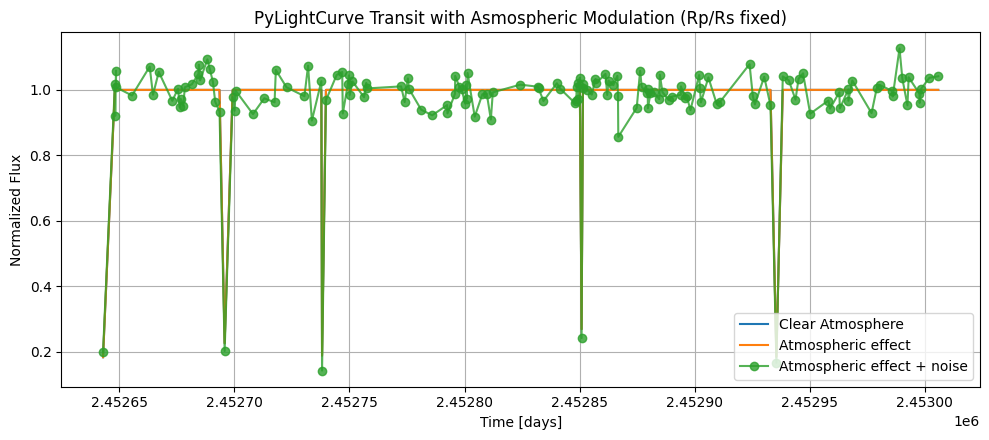

In [5]:
# === Plot the light curves ===
time_array, flux_clean, flux_clean_atm, flux_noisy_atm, num_epochs = modelling_light_curve(planet)
print('Number of epochs per year is', num_epochs)
plt.figure(figsize=(10, 4.5))
plt.plot(time_array, flux_clean, label="Clear Atmosphere")
plt.plot(time_array, flux_clean_atm,label="Atmospheric effect")
plt.plot(time_array, flux_noisy_atm, 'o-', label="Atmospheric effect + noise", alpha=0.8)
plt.xlabel("Time [days]")
plt.ylabel("Normalized Flux")
plt.title("PyLightCurve Transit with Asmospheric Modulation (Rp/Rs fixed)")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## 1.2. Detecting Variability Period  in the light curve with QHx

### 1.2.1. Detecting variability period with a single frequency window 

*** Starting Weighted Wavelet Z-transform ***

adjusted time_divisions to:  153
Pseudo sample frequency (median) is  0.625
largest tau window is  2.387
43.11 seconds has passed to complete Weighted Wavelet Z-transform 



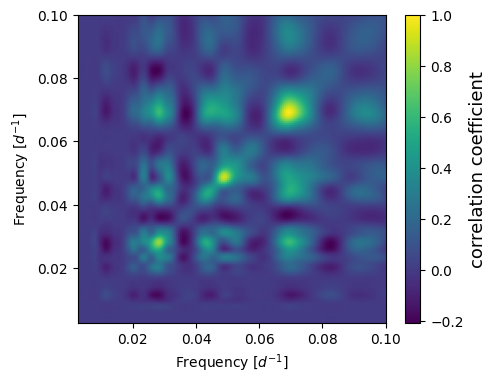

In [6]:
# Compute wavelet transforms of the light curve
# Then perform 2D cross-correlation of these wavelet matrices to detect coherent periodic signals
ngrid = 150   # number of grid points used in wavelet transform
ntau = 300    # number of discrete time lag considered in cross-correlation analysis
minfq, maxfq = 400, 10    # maximum and minimum periods considered in wavelet transform

wwz_matrix, corr, extent = hybrid2d(time_array, flux_noisy_atm, ntau, ngrid, minfq=minfq, maxfq=maxfq)

# Plotting wwz matrix heatmap
plt_freq_heatmap(corr, extent)

Period: 35.907, upper error :  2.07  lower error :  4.76
Period: 14.399, upper error : 10.34  lower error :  0.26


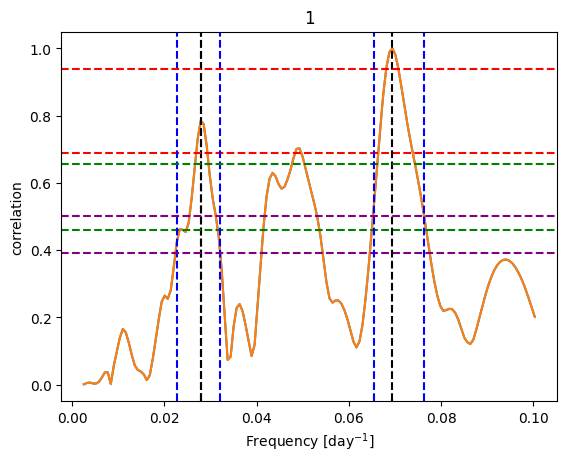

In [7]:
# Detect periods in the correlation matrix 
peaks0, hh0, r_periods0, up0, low0 = periods(1, corr, ngrid, plot=True, minfq=minfq, maxfq=maxfq)
   # peaks0, hh0: significance of the detected periods
   # r_periods0, up0, low0: detected periods and its upper/lower bound uncertainties

# Print obtained results
for j in range(len(r_periods0)):
    print("Period: %6.3f, upper error : %5.2f  lower error : %5.2f"% (r_periods0[j], up0[j], low0[j]) )

### 1.2.2. Detecting variability period with multiple frequency windows 

In [8]:
ngrid = 150
ntau = 100

window = np.array([1000,100,10,1,0.1,0.01])   # spectral windows of the periodicity detection study
N = len(window)  

ax, ay = [],[]
PERIOD,UP,LOW = [],[],[]

# Loop through all spectral windows
for i in tqdm(range(N-1)):
    minfq, maxfq = window[i]*0.99, window[i+1]
    with suppress_print():
        wwz_matrix, corr, extent = hybrid2d(time_array, flux_noisy_atm, ntau, ngrid, minfq=minfq, maxfq=maxfq)
    peaks0, hh0, r_periods0, up0, low0 = periods(i, corr, ngrid, plot=False, minfq=minfq, maxfq=maxfq)
    PERIOD.append(r_periods0)
    UP.append(up0)
    LOW.append(low0)
    
    fmin = 1 / minfq
    fmax = 1 / maxfq
    df = (fmax - fmin) / ngrid
    
    data = corr
    hh1 = np.rot90(data).T / np.rot90(data).T.max()
    hh1arr = np.rot90(hh1.T)
    hh1arr1 = np.abs(hh1arr).sum(1) / np.abs(hh1arr).sum(1).max()
    
    osax = np.arange(start=fmin, stop=fmax + df, step=df)
    xax = np.arange(start=fmin, stop=fmax + df, step=df / 2)
    f = interpolate.interp1d(osax, np.abs(hh1arr1), fill_value="extrapolate")
    yax = []
    for v in xax:
        yax.append(float(f(v)))
    yax = np.array(yax)
    ax.append(xax)
    ay.append(np.abs(yax))

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:17<00:00, 15.46s/it]


WINDOW 1000.0 - 100.0 : no detected period
WINDOW 100.0 - 10.0 :
      period: 35.6115107913669 , upper error: 9.116800546179327 , lower error: 1.4936852318617468
      period: 14.40209485016002 , upper error: 11.795902868264724 , lower error: 0.5404626736946625
WINDOW 10.0 - 1.0 :
      period: 6.2133891213389125 , upper error: 0.6125665852210282 , lower error: 0.35255444225090304
WINDOW 1.0 - 0.1 : no detected period
WINDOW 0.1 - 0.01 : no detected period


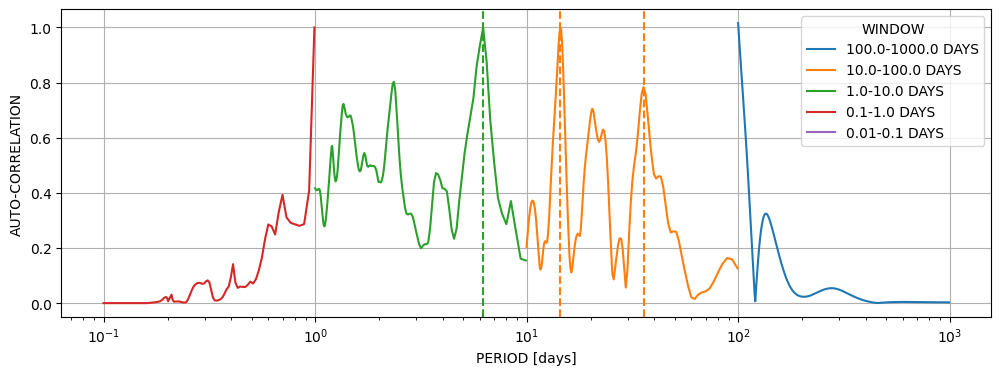

In [9]:
# Print the detected period in each window
for j in range(len(PERIOD)):
    if PERIOD[j]==[]:
        print('WINDOW',window[j],'-',window[j+1],': no detected period')
    else:          
        print('WINDOW',window[j],'-',window[j+1],':')
        for i,k in enumerate(PERIOD[j]):
            print('      period:',PERIOD[j][i],', upper error:',UP[j][i],', lower error:',LOW[j][i])

# Plot the autocorrelation of each period value
plt.figure(figsize=(12,4))
for i in range(len(ax)):
    labeli = str(window[i+1])+'-'+str(window[i])+' DAYS'
    linei, = plt.plot(1/ax[i],ay[i],label=labeli)
    if PERIOD[i]!=[]:
        for j,k in enumerate(PERIOD[i]):
            plt.axvline(x=PERIOD[i][j],linestyle='dashed',color=linei.get_color())
plt.xscale('log')
plt.xlabel('PERIOD [days]')
plt.ylabel('AUTO-CORRELATION')
legend = plt.legend()
legend.set_title('WINDOW')
plt.grid()
plt.show()

# 2. Testing Performance of QHx with large sample of light curve

## 2.1. Exploring the sample of planet light curves can be modelled with PyLightCurve

In [32]:
# Get all the real planets can be simulated with PyLightCurve
all_planets = plc.get_all_planets()
num_planets = len(all_planets)
print("Total number of real planets can be simulated with PyLightCurve:",num_planets)

Total number of real planets can be simulated with PyLightCurve: 776


In [33]:
# Get a subsample of the planets for our study
num_used_planets = 694
random.seed(500)
rand_index = np.array(random.sample(range(0, num_planets), num_used_planets))     # Get a set of random index 
                                                                                  # to extract from the large sample

# Get the period of the planets in our subsample
PERIOD_sample = [] 
for i in rand_index:
    planet_i = plc.get_planet(all_planets[i])
    PERIOD_sample.append(planet_i.period)

# Get the period of the planets of the whole PyLightCurve sample
# PERIOD_whole_data = []    
# for i in range(num_planets):
#     planet_i = plc.get_planet(all_planets[i])
#     PERIOD_whole_data.append(planet_i.period)

In [8]:
def histo(dat, bins):
    hist, bin_edges = np.histogram(dat,bins=bins)
    bin_centars = (bin_edges[:-1] + bin_edges[1:])/2
    return bin_centars, hist
def plot_hist(dat,bins,label):
    bin_centars,hist = histo(dat,bins)
    plt.plot(bin_centars,hist,linewidth=2,label=label)

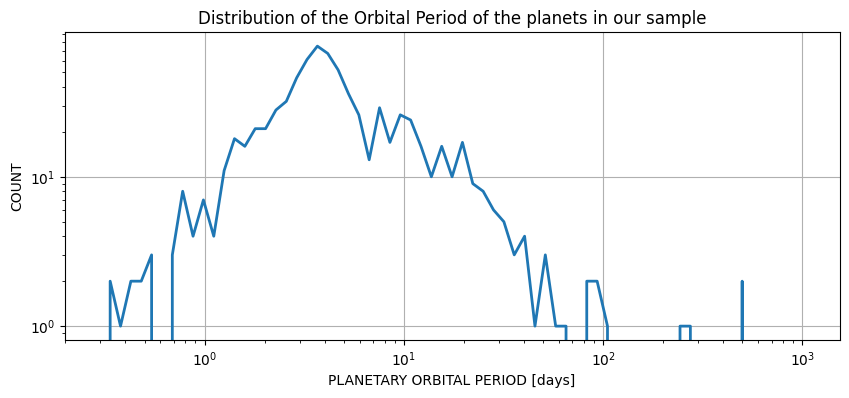

In [16]:
# Plot the distribution of the period of the planets in our sample 
plt.figure(figsize=(10,4))
bins = np.logspace(np.log10(np.min(PERIOD_sample)), np.log10(np.max(PERIOD_sample)),70)
# bins = np.logspace(np.log10(np.min(PERIOD_whole_data)), np.log10(np.max(PERIOD_whole_data)),70)
# plot_hist(PERIOD_whole_data,bins,'PyLightCurve Large sample')
plot_hist(PERIOD_sample,bins,'Our Subsample')
# plt.legend()
plt.title('Distribution of the Orbital Period of the planets in our sample')
plt.xlabel('PLANETARY ORBITAL PERIOD [days]')
plt.ylabel('COUNT')
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.show()

## 2.2. Detecting Atmospheric Effects with this sample 

In [14]:
# Function to detect atmohspheric effect 
def atm_detector(t_array,flux,minfq,maxfq):
    ngrid = 120
    ntau = 80
    with suppress_print():
        wwz_matrix, corr, extent = hybrid2d(t_array, flux, ntau, ngrid, minfq=minfq, maxfq=maxfq)
    peaks0, hh0, r_periods0, up0, low0 = periods(i, corr, ngrid, plot=False, minfq=minfq, maxfq=maxfq)
    if peaks0 != []:
        return True
    else:
        return False

In [1]:
# Get all the variability can be detected with this sample
NUM_EPOCHS_SAMPLE = []

PERIOD_CLOUD_DETECTED = []
NUM_EPOCHS_CLOUD_DETECTED = []

PERIOD_PHOTOCHEM_DETECTED = []
NUM_EPOCHS_PHOTOCHEM_DETECTED = []

for i in tqdm(range(len(rand_index))):
    planet_i = plc.get_planet(all_planets[rand_index[i]])
    with suppress_print():
        time_array, flux_clean, flux_clean_atm, flux_noisy_atm, num_epochs = modelling_light_curve(planet_i)
        
    NUM_EPOCHS_SAMPLE.append(num_epochs)
    
    # Detect cloud variability
    if atm_detector(time_array, flux_noisy_atm, 36/24, 1/24):
        PERIOD_CLOUD_DETECTED.append(PERIOD_sample[i])
        NUM_EPOCHS_CLOUD_DETECTED.append(num_epochs)
        
    # Detect photochemical cycle variability
    if atm_detector(time_array, flux_noisy_atm, 12*30, 1.5*30):
        PERIOD_PHOTOCHEM_DETECTED.append(PERIOD_sample[i])
        NUM_EPOCHS_PHOTOCHEM_DETECTED.append(num_epochs)   

In [66]:
# Save to files for future use due to long processing timescale
np.savetxt('PERIOD_sample.txt',PERIOD_sample)
np.savetxt('PERIOD_CLOUD_DETECTED.txt',PERIOD_CLOUD_DETECTED)
np.savetxt('PERIOD_PHOTOCHEM_DETECTED.txt',PERIOD_PHOTOCHEM_DETECTED)
np.savetxt('NUM_EPOCHS_SAMPLE.txt',NUM_EPOCHS_SAMPLE)
np.savetxt('NUM_EPOCHS_CLOUD_DETECTED.txt',NUM_EPOCHS_CLOUD_DETECTED)
np.savetxt('NUM_EPOCHS_PHOTOCHEM_DETECTED.txt',NUM_EPOCHS_PHOTOCHEM_DETECTED)

In [9]:
# Load files again if do not want to run again
PERIOD_sample = np.loadtxt('PERIOD_sample.txt')
PERIOD_CLOUD_DETECTED = np.loadtxt('PERIOD_CLOUD_DETECTED.txt')
PERIOD_PHOTOCHEM_DETECTED = np.loadtxt('PERIOD_PHOTOCHEM_DETECTED.txt')
NUM_EPOCHS_SAMPLE = np.loadtxt('NUM_EPOCHS_SAMPLE.txt')
NUM_EPOCHS_CLOUD_DETECTED = np.loadtxt('NUM_EPOCHS_CLOUD_DETECTED.txt')
NUM_EPOCHS_PHOTOCHEM_DETECTED = np.loadtxt('NUM_EPOCHS_PHOTOCHEM_DETECTED.txt')

In [7]:
# PERIOD_sample = PERIOD_sample [:len(NUM_EPOCHS_SAMPLE)]

### 2.2.1. Distribution of number of detected atmospheric variability  

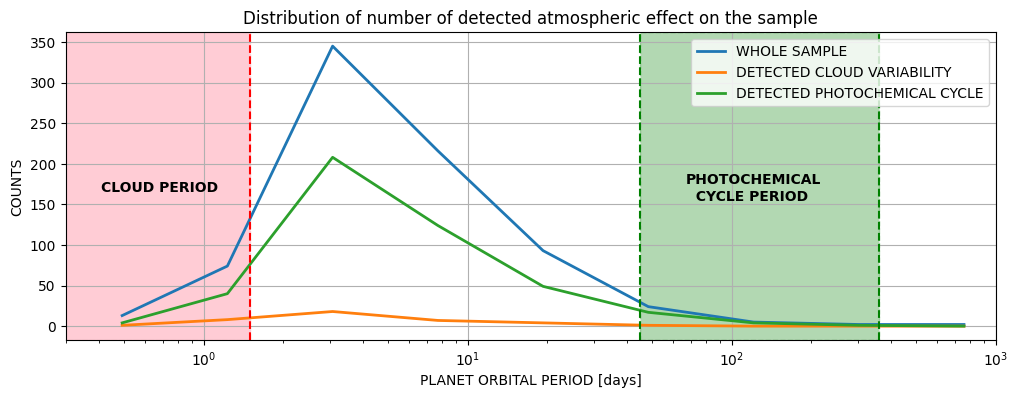

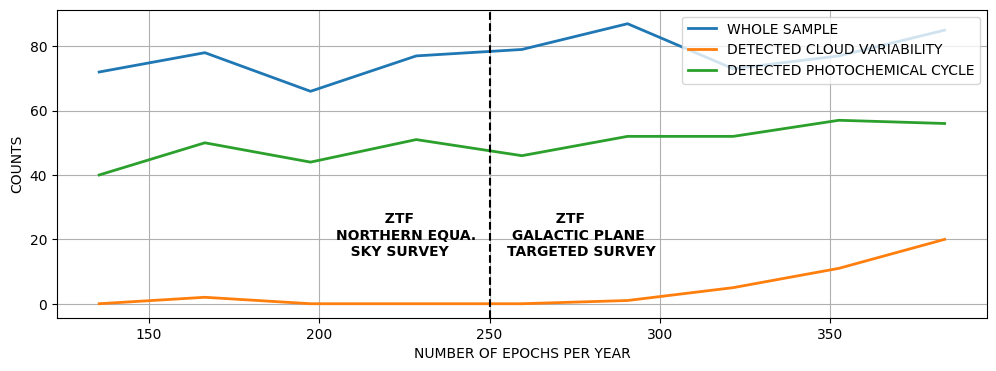

In [38]:
plt.figure(figsize=(12,4))
plt.title('Distribution of number of detected atmospheric effect on the sample')
bins_periods = np.logspace(np.log10(np.min(PERIOD_sample)), np.log10(np.max(PERIOD_sample)),10)
plt.xscale('log')
plot_hist(PERIOD_sample,bins_periods,'WHOLE SAMPLE')
plot_hist(PERIOD_CLOUD_DETECTED,bins_periods,'DETECTED CLOUD VARIABILITY')
plot_hist(PERIOD_PHOTOCHEM_DETECTED,bins_periods,'DETECTED PHOTOCHEMICAL CYCLE')
plt.xlabel('PLANET ORBITAL PERIOD [days]')
plt.ylabel('COUNTS')
plt.legend()
plt.axvline(x=1/24,linestyle='dashed',color='red')
plt.axvline(x=36/24,linestyle='dashed',color='red')
plt.axvline(x=1.5*30,linestyle='dashed',color='green')
plt.axvline(x=12*30,linestyle='dashed',color='green')
plt.axvspan(1/24,36/24, color='pink',alpha=0.8,linestyle='dashed')
plt.axvspan(1.5*30,12*30, color='green',alpha=0.3,linestyle='dashed')
plt.annotate('CLOUD PERIOD',(0.41,165),fontweight='bold')
plt.annotate('PHOTOCHEMICAL\n  CYCLE PERIOD',(67,155),fontweight='bold')
plt.grid()
plt.xlim([3e-1,1000])
plt.show()

plt.figure(figsize=(12,4))
bins_epochs = np.linspace(np.min(NUM_EPOCHS_SAMPLE), np.max(NUM_EPOCHS_SAMPLE),10)
plot_hist(NUM_EPOCHS_SAMPLE,bins_epochs,'WHOLE SAMPLE')
plot_hist(NUM_EPOCHS_CLOUD_DETECTED,bins_epochs,'DETECTED CLOUD VARIABILITY')
plot_hist(NUM_EPOCHS_PHOTOCHEM_DETECTED,bins_epochs,'DETECTED PHOTOCHEMICAL CYCLE')
plt.axvline(x=250, linestyle='dashed',color='black')
plt.xlabel('NUMBER OF EPOCHS PER YEAR')
plt.ylabel('COUNTS')
plt.legend(loc='upper right')
plt.grid()
plt.annotate('          ZTF\nNORTHERN EQUA.\n   SKY SURVEY',(205,15),fontweight='bold')
plt.annotate('          ZTF\n GALACTIC PLANE\nTARGETED SURVEY',(255,15),fontweight='bold')

plt.show()

### 2.2.2. Recovery rate of detecting atmospheric effects with QHx 

In [11]:
# Calculate the recovery rate of detecting atmospheric variability
def RECOVERY_RATE(dat_x, dat_y, bins):
    recovery_rate = []
    bin_centars, hist_dat_y = histo(dat_y, bins)
    bin_centars, hist_dat_x = histo(dat_x, bins)
    for i,k in enumerate(hist_dat_y):
        if hist_dat_y[i] == 0:
            recovery_rate.append(0)
        else:
            recovery_rate.append(hist_dat_x[i]/hist_dat_y[i]*100)
    return bin_centars, recovery_rate

bins_period = np.logspace(np.log10(np.min(PERIOD_sample)), np.log10(np.max(PERIOD_sample)),10)
bin_centars_period, RECOVERY_RATE_PERIOD_CLOUD = RECOVERY_RATE(PERIOD_CLOUD_DETECTED, PERIOD_sample, bins_period)
bin_centars_period, RECOVERY_RATE_PERIOD_PHOTOCHEM = RECOVERY_RATE(PERIOD_PHOTOCHEM_DETECTED, PERIOD_sample, bins_period)

bins_epochs = np.linspace(np.min(NUM_EPOCHS_SAMPLE), np.max(NUM_EPOCHS_SAMPLE),10)
bin_centars_epochs, RECOVERY_RATE_EPOCHS_CLOUD = RECOVERY_RATE(NUM_EPOCHS_CLOUD_DETECTED, NUM_EPOCHS_SAMPLE, bins_epochs)
bin_centars_epochs, RECOVERY_RATE_EPOCHS_PHOTOCHEM = RECOVERY_RATE(NUM_EPOCHS_PHOTOCHEM_DETECTED, 
                                                                   NUM_EPOCHS_SAMPLE, 
                                                                   bins_epochs)

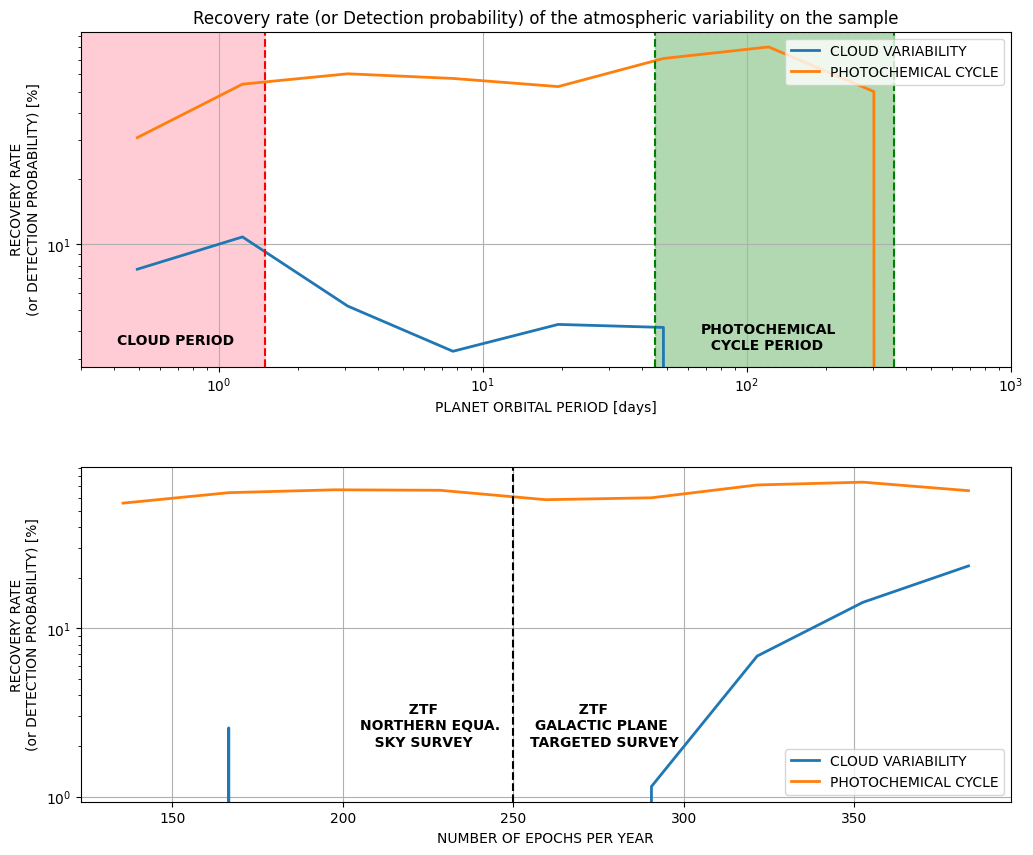

In [47]:
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.title('Recovery rate (or Detection probability) of the atmospheric variability on the sample')
plt.plot(bin_centars_period, RECOVERY_RATE_PERIOD_CLOUD, label = 'CLOUD VARIABILITY', linewidth=2)
plt.plot(bin_centars_period, RECOVERY_RATE_PERIOD_PHOTOCHEM, label = 'PHOTOCHEMICAL CYCLE', linewidth=2)
plt.legend(loc='upper right')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('PLANET ORBITAL PERIOD [days]')
plt.ylabel('RECOVERY RATE\n(or DETECTION PROBABILITY) [%]')
plt.axvline(x=1/24,linestyle='dashed',color='red')
plt.axvline(x=36/24,linestyle='dashed',color='red')
plt.axvline(x=1.5*30,linestyle='dashed',color='green')
plt.axvline(x=12*30,linestyle='dashed',color='green')
plt.axvspan(1/24,36/24, color='pink',alpha=0.8,linestyle='dashed')
plt.axvspan(1.5*30,12*30, color='green',alpha=0.3,linestyle='dashed')
plt.annotate('CLOUD PERIOD',(0.41,3.5),fontweight='bold')
plt.annotate('PHOTOCHEMICAL\n  CYCLE PERIOD',(67,3.3),fontweight='bold')
plt.grid()
plt.xlim([3e-1,1000])

plt.subplot(2,1,2)
plt.plot(bin_centars_epochs, RECOVERY_RATE_EPOCHS_CLOUD, label = 'CLOUD VARIABILITY', linewidth=2)
plt.plot(bin_centars_epochs, RECOVERY_RATE_EPOCHS_PHOTOCHEM, label = 'PHOTOCHEMICAL CYCLE', linewidth=2)
plt.axvline(x=250, linestyle='dashed',color='black')
plt.legend()
plt.grid()
plt.xlabel('NUMBER OF EPOCHS PER YEAR')
plt.ylabel('RECOVERY RATE\n(or DETECTION PROBABILITY) [%]')
plt.yscale('log')
plt.annotate('          ZTF\nNORTHERN EQUA.\n   SKY SURVEY',(205,2),fontweight='bold')
plt.annotate('          ZTF\n GALACTIC PLANE\nTARGETED SURVEY',(255,2),fontweight='bold')
plt.subplots_adjust(hspace=0.3)
plt.show()

# <center>Conclusion</center>
### <center>1. Possible to use QHx to detect periodic atmospheric effects</center>
### <center>2. Posible to mistakenly detect planet orbital period for atmospheric effects OR enhance its signature</center>
### <center>3. Photochemical cycle effect is largely independent of cadence of observations</center>
### <center>4. Minimum cadence required for detecting cloud variability is roughly 290 epochs/year</center>